In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install segmentation-models-pytorch

In [ ]:
!pip install albumentations

In [ ]:
# for data load
import os
import pandas as pd
from glob import glob
import segmentation_models_pytorch as smp
import tensorflow as tf
from segmentation_models_pytorch.losses import DiceLoss
import torch.nn as nn
import torch
import numpy as np
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

# for reading and processing images
import imageio
from PIL import Image

# for visualizations
import matplotlib.pyplot as plt

import numpy as np # for using np arrays

# for bulding and running deep learning model
from sklearn.metrics import precision_score, recall_score, jaccard_score
from scipy.spatial.distance import directed_hausdorff
from sklearn.model_selection import train_test_split
from google.colab import files



In [ ]:
#upload kaggle token and download dataset

!mkdir -p ~/.kaggle
!mv /content/kaggle.json ~/.kaggle/

!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation
!unzip lgg-mri-segmentation.zip -d /content/dataset

In [ ]:
def LoadData (path1, path2):
    """
    Looks for relevant filenames in the shared path
    Returns 2 lists for original and masked files respectively

    """
    # Read the images folder like a list

    # Make a list for images and masks filenames
    orig_img = []
    mask_img = []
    for file in path1:
        orig_img.append(file)
    for file in path2:
        mask_img.append(file)

    # Sort the lists to get both of them in same order (the dataset has exactly the same name for images and corresponding masks)
    orig_img.sort()
    mask_img.sort()

    return orig_img, mask_img



In [ ]:
def PreprocessData(img, mask, target_shape_img, target_shape_mask, path1, path2, n_slices=3):
    """
    Processes the images and mask present in the shared list and path.
    Each input sample includes `n_slices` adjacent slices (center ±N).
    Returns:
        X - Image stack of shape (m, H, W, n_slices)
        y - Corresponding masks of shape (m, H, W, 1)
    """
    import numpy as np
    from PIL import Image
    import os

    m = len(img)  # number of total slices
    i_h, i_w, _ = target_shape_img
    m_h, m_w, m_c = target_shape_mask

    # Image shape now includes n_slices as channels
    X = np.zeros((m, i_h, i_w, n_slices), dtype=np.float32)
    y = np.zeros((m, m_h, m_w, m_c), dtype=np.float32)

    half = n_slices // 2

    for index in range(m):
        slice_stack = []

        for offset in range(-half, half + 1):
            slice_idx = index + offset
            # Handle boundaries by clamping the index
            slice_idx = max(0, min(slice_idx, m - 1))
            adj_file = img[slice_idx]
            adj_path = os.path.join(path1[slice_idx], adj_file)

            adj_img = Image.open(adj_path).convert('L')  # grayscale
            adj_img = adj_img.resize((i_h, i_w))
            adj_img = np.array(adj_img, dtype=np.float32) / 255.0
            slice_stack.append(adj_img)

        # Stack into (H, W, n_slices)
        stacked_img = np.stack(slice_stack, axis=-1)
        X[index] = stacked_img

        # Load and process mask (same as original)
        mask_file = mask[index]
        mask_path = os.path.join(path2[index], mask_file)
        single_mask = Image.open(mask_path)
        single_mask = single_mask.resize((m_h, m_w))
        single_mask = np.array(single_mask, dtype=np.float32)
        single_mask[single_mask == 255] = 1
        single_mask[single_mask > 1] = 1
        single_mask = np.reshape(single_mask, (m_h, m_w, m_c))
        y[index] = single_mask

    return X, y


In [ ]:
def compute_metrics(y_true, y_pred):
    y_pred_bin = (y_pred > 0.5).astype(np.uint8)  # Convert to binary mask

    dice = dice_coefficient(y_true, y_pred_bin).numpy()
    iou_score = iou(y_true, y_pred_bin).numpy()

    precision = precision_score(y_true.flatten(), y_pred_bin.flatten(), zero_division=1)
    recall = recall_score(y_true.flatten(), y_pred_bin.flatten(), zero_division=1)

    hausdorff_dist = directed_hausdorff(y_true.squeeze(), y_pred_bin.squeeze())[0]

    return {
        'Dice Coefficient': dice,
        'IoU': iou_score,
        'Precision': precision,
        'Recall': recall,
        'Hausdorff Distance': hausdorff_dist
    }


In [ ]:
def get_file_row(path):
    """Produces ID of a patient, image and mask filenames from a particular path"""
    path_no_ext, ext = os.path.splitext(path)
    filename = os.path.basename(path)

    patient_id = '_'.join(filename.split('_')[:3]) # Patient ID in the csv file consists of 3 first filename segments

    return [patient_id, path, f'{path_no_ext}_mask{ext}']

files_dir = '/content/dataset/lgg-mri-segmentation/kaggle_3m'
file_paths = glob(f'{files_dir}/*/*[0-9].tif')
train_df = pd.DataFrame((get_file_row(filename) for filename in file_paths), columns=['Patient', 'image_filename', 'mask_filename'])
print(train_df)
'''


def is_valid_mask(mask_path, threshold=0.00001):
    """Returns True if at least `threshold` of pixels are non-black."""
    mask = Image.open(mask_path).convert('L')
    mask_array = np.array(mask)
    non_black_ratio = np.count_nonzero(mask_array) / mask_array.size
    return non_black_ratio >= threshold

# Separate valid and invalid
valid_df = train_df[train_df['mask_filename'].apply(is_valid_mask)]
invalid_df = train_df[~train_df['mask_filename'].apply(is_valid_mask)]

# Keep 20% of the invalid ones
invalid_sampled = invalid_df.sample(frac=1, random_state=42)

# Combine back
filtered_df = pd.concat([valid_df, invalid_sampled]).reset_index(drop=True)

print(f"Filtered dataset size: {len(filtered_df)} / {len(train_df)}")

# Filter out rows with masks that are too empty to be considered (1373 usable)
#filtered_df = train_df[train_df['mask_filename'].apply(is_valid_mask)].reset_index(drop=True)

#print(f"Filtered dataset size: {len(filtered_df)} / {len(train_df)}")
#print(filtered_df)

#print(train_df)
'''

           Patient                                     image_filename  \
0     TCGA_HT_7884  /content/dataset/lgg-mri-segmentation/kaggle_3...   
1     TCGA_HT_7884  /content/dataset/lgg-mri-segmentation/kaggle_3...   
2     TCGA_HT_7884  /content/dataset/lgg-mri-segmentation/kaggle_3...   
3     TCGA_HT_7884  /content/dataset/lgg-mri-segmentation/kaggle_3...   
4     TCGA_HT_7884  /content/dataset/lgg-mri-segmentation/kaggle_3...   
...            ...                                                ...   
3924  TCGA_DU_7010  /content/dataset/lgg-mri-segmentation/kaggle_3...   
3925  TCGA_DU_7010  /content/dataset/lgg-mri-segmentation/kaggle_3...   
3926  TCGA_DU_7010  /content/dataset/lgg-mri-segmentation/kaggle_3...   
3927  TCGA_DU_7010  /content/dataset/lgg-mri-segmentation/kaggle_3...   
3928  TCGA_DU_7010  /content/dataset/lgg-mri-segmentation/kaggle_3...   

                                          mask_filename  
0     /content/dataset/lgg-mri-segmentation/kaggle_3...  
1     /

'\n\n\ndef is_valid_mask(mask_path, threshold=0.00001):\n    """Returns True if at least `threshold` of pixels are non-black."""\n    mask = Image.open(mask_path).convert(\'L\')\n    mask_array = np.array(mask)\n    non_black_ratio = np.count_nonzero(mask_array) / mask_array.size\n    return non_black_ratio >= threshold\n\n# Separate valid and invalid\nvalid_df = train_df[train_df[\'mask_filename\'].apply(is_valid_mask)]\ninvalid_df = train_df[~train_df[\'mask_filename\'].apply(is_valid_mask)]\n\n# Keep 20% of the invalid ones\ninvalid_sampled = invalid_df.sample(frac=1, random_state=42)\n\n# Combine back\nfiltered_df = pd.concat([valid_df, invalid_sampled]).reset_index(drop=True)\n\nprint(f"Filtered dataset size: {len(filtered_df)} / {len(train_df)}")\n\n# Filter out rows with masks that are too empty to be considered (1373 usable)\n#filtered_df = train_df[train_df[\'mask_filename\'].apply(is_valid_mask)].reset_index(drop=True)\n\n#print(f"Filtered dataset size: {len(filtered_df)} / {

In [ ]:
patient_info = pd.read_csv('/content/dataset/lgg-mri-segmentation/kaggle_3m/data.csv')

train_df['Patient'] = train_df['image_filename'].apply(lambda x: os.path.basename(x).split('_')[0] + '_' + os.path.basename(x).split('_')[1] + '_' + os.path.basename(x).split('_')[2])

# Map race to each filename
#map = dict(zip(patient_info['Patient'], patient_info['race']))
#train_df['race'] = train_df['Patient'].map(map)

train_df = train_df.merge(
    patient_info[['Patient', 'race', 'gender']],
    on='Patient',
    how='left'
)
print(train_df)

           Patient                                     image_filename  \
0     TCGA_HT_7884  /content/dataset/lgg-mri-segmentation/kaggle_3...   
1     TCGA_HT_7884  /content/dataset/lgg-mri-segmentation/kaggle_3...   
2     TCGA_HT_7884  /content/dataset/lgg-mri-segmentation/kaggle_3...   
3     TCGA_HT_7884  /content/dataset/lgg-mri-segmentation/kaggle_3...   
4     TCGA_HT_7884  /content/dataset/lgg-mri-segmentation/kaggle_3...   
...            ...                                                ...   
3924  TCGA_DU_7010  /content/dataset/lgg-mri-segmentation/kaggle_3...   
3925  TCGA_DU_7010  /content/dataset/lgg-mri-segmentation/kaggle_3...   
3926  TCGA_DU_7010  /content/dataset/lgg-mri-segmentation/kaggle_3...   
3927  TCGA_DU_7010  /content/dataset/lgg-mri-segmentation/kaggle_3...   
3928  TCGA_DU_7010  /content/dataset/lgg-mri-segmentation/kaggle_3...   

                                          mask_filename  race  gender  
0     /content/dataset/lgg-mri-segmentation/kaggle_

/tmp/ipython-input-3247516104.py:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_view  = imageio.imread(path1[i])
/tmp/ipython-input-3247516104.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask_view = imageio.imread(path2[i])


(256, 256, 3)
(256, 256)


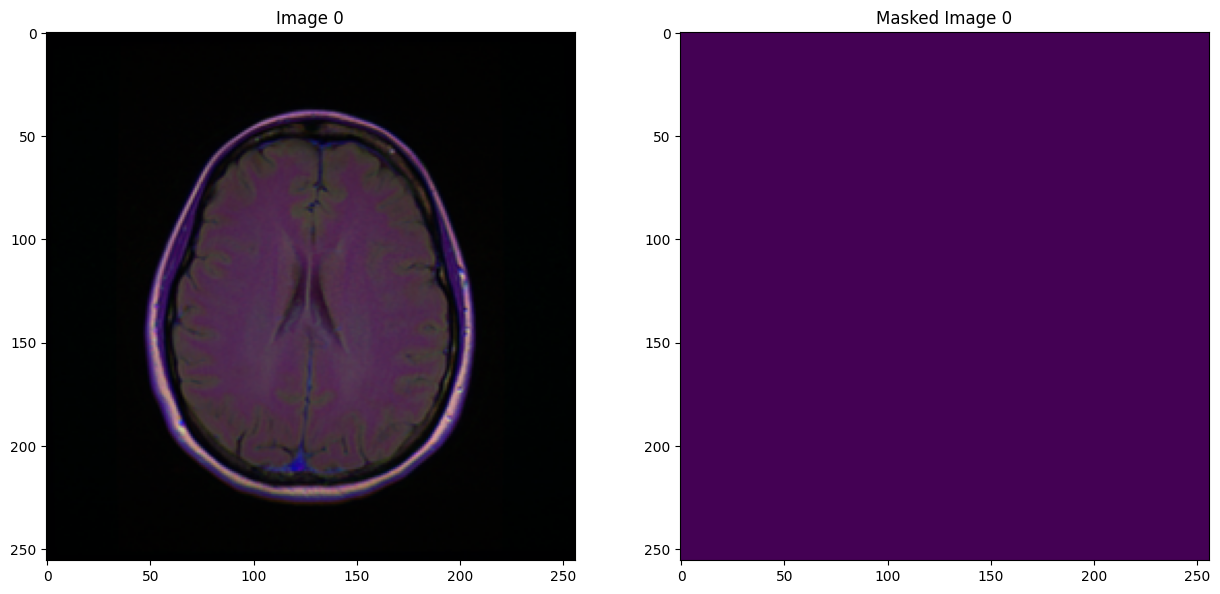

In [ ]:
""" Load Train Set and view some examples """
# Call the apt function
path1 = train_df["image_filename"].tolist()
path2 = train_df["mask_filename"].tolist()
img, mask = LoadData (path1, path2)


# View an example of image and corresponding mask
show_images = 1
for i in range(show_images):
    img_view  = imageio.imread(path1[i])
    mask_view = imageio.imread(path2[i])
    print(img_view.shape)
    print(mask_view.shape)
    fig, arr = plt.subplots(1, 2, figsize=(15, 15))
    arr[0].imshow(img_view)
    arr[0].set_title('Image '+ str(i))
    arr[1].imshow(mask_view)
    arr[1].set_title('Masked Image '+ str(i))

X Shape: (3929, 256, 256, 3)
Y shape: (3929, 256, 256, 1)
[0. 1.]


Text(0.5, 1.0, 'Processed Masked Image')

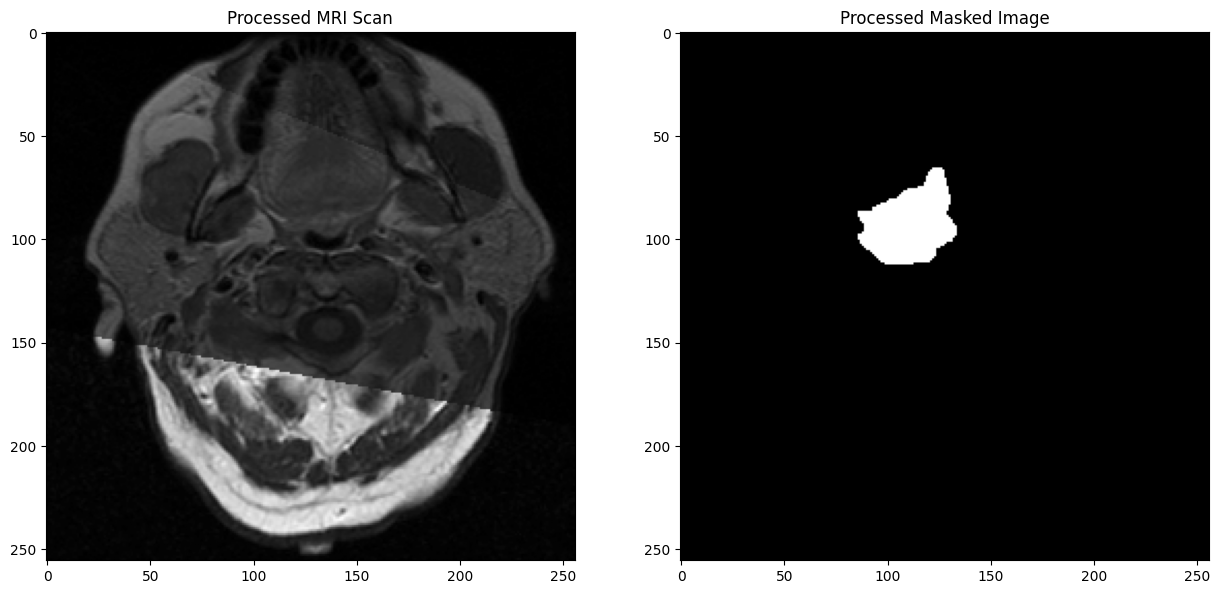

In [ ]:
# Define the desired shape
target_shape_img = [256, 256, 3]
target_shape_mask = [256, 256, 1]

# Process data using apt helper function
X, y = PreprocessData(img, mask, target_shape_img, target_shape_mask, path1, path2)

# QC the shape of output and classes in output dataset
print("X Shape:", X.shape)
print("Y shape:", y.shape)
# There are 2 classes : background, tumor
print(np.unique(y))

# Visualize the output
image_index = 1
fig, arr = plt.subplots(1, 2, figsize=(15, 15))
arr[0].imshow(X[image_index, :, :, 0], cmap='gray')  # Show MRI image in grayscale
arr[0].set_title('Processed MRI Scan')

arr[1].imshow(y[image_index, :, :, 0], cmap='gray')  # Show mask in grayscale
arr[1].set_title('Processed Masked Image')


In [ ]:
# Use scikit-learn's function to split the dataset
# Here, I have used 20% data as test/valid set# --- Patient-level train/val split ---
patients = train_df["Patient"].unique()
train_patients, val_patients = train_test_split(
    patients, test_size=0.2, random_state=42
)

train_df_split = train_df[train_df["Patient"].isin(train_patients)]
val_df_split = train_df[train_df["Patient"].isin(val_patients)]

# Prepare file lists
train_images, train_masks = LoadData(
    train_df_split["image_filename"].tolist(),
    train_df_split["mask_filename"].tolist()
)
val_images, val_masks = LoadData(
    val_df_split["image_filename"].tolist(),
    val_df_split["mask_filename"].tolist()
)

# Process into arrays with new 256x256 size
X_train, y_train = PreprocessData(
    train_images, train_masks,
    target_shape_img, target_shape_mask,
    train_df_split["image_filename"].tolist(),
    train_df_split["mask_filename"].tolist()
)

X_valid, y_valid = PreprocessData(
    val_images, val_masks,
    target_shape_img, target_shape_mask,
    val_df_split["image_filename"].tolist(),
    val_df_split["mask_filename"].tolist()
)


In [ ]:
# =========================
# Dataset with Albumentations
# =========================
class SegmentationDataset(Dataset):
    def __init__(self, images, masks, augment=None):
        self.images = images  # already numpy arrays
        self.masks = masks    # already numpy arrays
        self.augment = augment

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]   # shape [H,W,C]
        mask = self.masks[idx]     # shape [H,W,1] or [H,W]

        # Ensure correct types
        image = image.astype(np.float32)
        mask = mask.astype(np.float32)
        mask = (mask > 0.5).astype(np.float32)  # binarize

        # Albumentations expects HWC
        if self.augment:
            augmented = self.augment(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]

        # Convert to tensors
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)  # [C,H,W]
        if mask.ndim == 2:  # [H,W]
            mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)    # [1,H,W]
        else:  # [H,W,1]
            mask = torch.tensor(mask, dtype=torch.float32).permute(2, 0, 1)

        return image, mask



# =========================
# Augmentation Pipelines
# =========================
imagenet_mean = (0.485, 0.456, 0.406)
imagenet_std = (0.229, 0.224, 0.225)

train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.ElasticTransform(p=0.3),
    A.Normalize(mean=imagenet_mean, std=imagenet_std),
])

valid_transform = A.Compose([
    A.Normalize(mean=imagenet_mean, std=imagenet_std),
])


# =========================
# Datasets and Loaders
# =========================
train_dataset = SegmentationDataset(
    X_train,
    y_train,
    augment=train_transform
)

val_dataset = SegmentationDataset(
    X_valid,
    y_valid,
    augment=valid_transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4
)

val_loader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4
)


In [ ]:
pip install torchmetrics

In [ ]:
from torchmetrics.classification import BinaryJaccardIndex, BinaryF1Score

In [ ]:
class BCEDiceLoss(nn.Module):
  def __init__(self, bce_weight=0.5):
    super().__init__()
    self.dice = smp.losses.DiceLoss(mode = "binary")
    self.bce = smp.losses.SoftBCEWithLogitsLoss()
    self.bce_weight = bce_weight

  def forward(self, inputs, targets):
    dice_loss = self.dice(inputs, targets)
    bce_loss = self.bce(inputs, targets)
    return self.bce_weight * bce_loss + (1 - self.bce_weight) * dice_loss

In [ ]:
# Initialize metrics
import torch
import numpy as np
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics.classification import BinaryJaccardIndex, BinaryF1Score
from segmentation_models_pytorch.metrics import get_stats, iou_score, f1_score
iou_metric = BinaryJaccardIndex(threshold=0.5)
f1_metric = BinaryF1Score(threshold=0.5)

def train_model(model, train_loader, val_loader, optimizer, loss_fn, num_epochs):
    best_iou = 0.0
    best_threshold = 0.5

    history = {
        'train_loss': [],
        'val_loss': [],
        'iou_score': [],
        'f1_score': [],
        'best_threshold': []
    }

    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, min_lr=1e-6)

    for epoch in range(num_epochs):
        # -------- Training --------
        model.train()
        train_losses = []
        for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            train_losses.append(loss.item())
            loss.backward()
            optimizer.step()
        avg_train_loss = np.mean(train_losses)

        # -------- Validation --------
        model.eval()
        val_losses, all_preds, all_targets = [], [], []
        with torch.no_grad():
            for inputs, targets in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Valid]"):
                outputs = model(inputs)
                loss = loss_fn(outputs, targets)
                val_losses.append(loss.item())
                probs = torch.sigmoid(outputs)
                all_preds.append(probs.cpu())
                all_targets.append(targets.cpu())

        # Concatenate
        all_preds = torch.cat(all_preds, dim=0)
        all_targets = torch.cat(all_targets, dim=0)
        avg_val_loss = np.mean(val_losses)

        # -------- Dynamic threshold search --------
        thresholds = np.linspace(0.3, 0.7, 9)
        best_epoch_iou, best_epoch_thr = 0.0, 0.5
        for thr in thresholds:
            preds_bin = (all_preds > thr).float()

# Get stats from predictions and targets
            stats = get_stats(preds_bin.long(), all_targets.long(), mode='binary')

# Compute IoU from stats
            iou = iou_score(*stats)
            iou = iou.mean().item()
            if iou > best_epoch_iou:
                best_epoch_iou, best_epoch_thr = iou, thr

        # F1 at that threshold
        preds_bin = (all_preds > best_epoch_thr).float()
        stats_f1 = get_stats(preds_bin.long(), all_targets.long(), mode='binary')
        f1 = f1_score(*stats_f1)
        avg_f1 = f1.mean().item()

        # Scheduler step
        scheduler.step(best_epoch_iou)

        # Save best model
        if best_epoch_iou > best_iou:
            best_iou, best_threshold = best_epoch_iou, best_epoch_thr
            checkpoint = {
                "epoch": epoch,
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "scheduler_state": scheduler.state_dict(),
                "best_iou": best_iou,
                "best_threshold": best_threshold,
                "history": history
            }
            torch.save(checkpoint, f"checkpoint_best_epoch{epoch+1}_iou{best_iou:.4f}_thr{best_threshold:.2f}.pth")
            print(f"✅ Saved best model at IoU={best_iou:.4f}, thr={best_threshold:.2f}")

        # Store history
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['iou_score'].append(best_epoch_iou)
        history['f1_score'].append(avg_f1)
        history['best_threshold'].append(best_epoch_thr)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
        print(f"IoU: {best_epoch_iou:.4f} (thr={best_epoch_thr:.2f}) | F1: {avg_f1:.4f}")
        print("-" * 50)

    print(f"🏆 Best IoU overall: {best_iou:.4f} at threshold {best_threshold:.2f}")
    return history, best_threshold, best_iou

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_tensor_image(tensor, title="", is_mask=False):
    # Convert tensor to NumPy for display
    tensor = tensor.squeeze().cpu().numpy()  # Remove any singleton dimensions

    # If it's a mask, we use a different display method (usually binary)
    if is_mask:
        plt.imshow(tensor, cmap='gray')  # Show in grayscale
    else:
        # For images, ensure the tensor is in [H, W, C] format (matplotlib expects channel last)
        if len(tensor.shape) == 3:  # If it's a 3D tensor (e.g., RGB)
            tensor = np.transpose(tensor, (1, 2, 0))  # Change from [C, H, W] to [H, W, C]
        plt.imshow(tensor)

    plt.title(title)
    plt.axis('off')  # Hide axes for cleaner display
    plt.show()

In [ ]:
!pip install totalsegmentator

In [ ]:
import os
import pandas as pd
import numpy as np
import nibabel as nib
from PIL import Image
from totalsegmentator.python_api import totalsegmentator

def stack_slices_to_nifti(patient_df, out_path):
    """Stack patient slices into a 3D NIfTI file."""
    images = []
    for img_path in sorted(patient_df["image_filename"].tolist()):
        img = Image.open(img_path).convert("L")
        images.append(np.array(img))
    volume = np.stack(images, axis=-1)  # shape (H, W, D)
    nifti = nib.Nifti1Image(volume.astype(np.float32), affine=np.eye(4))
    nib.save(nifti, out_path)


import torch
import nibabel as nib
import numpy as np
from PIL import Image
from segmentation_models_pytorch.metrics import get_stats, iou_score, f1_score
from scipy.spatial.distance import directed_hausdorff

def evaluate_totalseg(mask_paths, pred_path, threshold=0.5):
    """
    Compare ground truth TIFF masks with TotalSegmentator NIfTI prediction,
    using same IoU/F1 calculation as training and adding Hausdorff distance.
    """
    # --- Load NIfTI prediction ---
    pred_nii = nib.load(pred_path)
    pred_volume = pred_nii.get_fdata()   # shape (H, W, D)

    # Binarize
    pred_volume = (pred_volume > threshold).astype(np.uint8)

    y_true_all = []
    y_pred_all = []

    # Align slices
    min_slices = min(pred_volume.shape[-1], len(mask_paths))

    for i in range(min_slices):
        gt_mask = np.array(Image.open(mask_paths[i]).convert("L"))
        gt_mask = (gt_mask > 127).astype(np.uint8)   # binarize ground truth

        pred_slice = pred_volume[:, :, i]

        # Resize prediction slice to match GT size if needed
        if pred_slice.shape != gt_mask.shape:
            pred_slice = np.array(
                Image.fromarray(pred_slice).resize(gt_mask.shape[::-1], Image.NEAREST)
            )

        y_true_all.append(gt_mask)
        y_pred_all.append(pred_slice)

    # Convert to torch tensors
    y_true_all = torch.tensor(np.stack(y_true_all)).unsqueeze(1).contiguous()
    y_pred_all = torch.tensor(np.stack(y_pred_all)).unsqueeze(1).contiguous()


    # --- Compute IoU & F1 ---
    preds_bin = (y_pred_all > threshold).float()
    stats = get_stats(preds_bin.long(), y_true_all.long(), mode='binary')
    iou = iou_score(*stats).mean().item()
    f1  = f1_score(*stats).mean().item()

    # --- Compute Hausdorff distance (on first slice with signal) ---
    y_true_np = y_true_all.squeeze().numpy()
    y_pred_np = preds_bin.squeeze().numpy()
    try:
        hausdorff = directed_hausdorff(y_true_np, y_pred_np)[0]
    except Exception:
        hausdorff = np.nan

    return {
        "Dice": f1,
        "IoU": iou,
        "Hausdorff": hausdorff
    }



def evaluate_totalseg_testset(test_df_split,
                              nifti_dir="/content/test_niftis",
                              results_dir="/content/test_results"):

    os.makedirs(nifti_dir, exist_ok=True)
    os.makedirs(results_dir, exist_ok=True)

    results_per_patient = []

    for patient, df in test_df_split.groupby("Patient"):
        race   = df["race"].iloc[0]   if "race"   in df.columns else "unknown"
        gender = df["gender"].iloc[0] if "gender" in df.columns else "unknown"

        # Prepare input/output paths
        nifti_input = os.path.join(nifti_dir, f"{patient}.nii.gz")
        nifti_output = os.path.join(results_dir, f"{patient}.nii")

        # Convert slices -> NIfTI
        stack_slices_to_nifti(df, nifti_input)

        # Run TotalSegmentator (saves as {patient}.nii in results_dir)
        print(f"🩻 Running TotalSegmentator for patient {patient} ...")
        totalsegmentator(nifti_input, nifti_output, ml=True)

        # Prediction file
        pred_path = os.path.join(results_dir, f"{patient}.nii")
        if not os.path.exists(pred_path):
            print(f"⚠️ Skipping {patient}: no prediction file found.")
            continue

        # Evaluate predictions
        metrics = evaluate_totalseg(df["mask_filename"].tolist(), pred_path)
        metrics["Patient"] = patient
        metrics["race"] = race
        metrics["gender"] = gender
        results_per_patient.append(metrics)

    results_df = pd.DataFrame(results_per_patient)

    if results_df.empty:
        print("⚠️ No results generated — check test set or TotalSegmentator output.")
        return results_df, None, None, None, None

    # --- Aggregate by race ---
    iou_by_race  = results_df.groupby("race")["IoU"].mean().reset_index()
    dice_by_race = results_df.groupby("race")["Dice"].mean().reset_index()

    # --- Aggregate by gender ---
    iou_by_gender  = results_df.groupby("gender")["IoU"].mean().reset_index()
    dice_by_gender = results_df.groupby("gender")["Dice"].mean().reset_index()

    print("📊 IoU by Race:\n", iou_by_race)
    print("📊 Dice by Race:\n", dice_by_race)
    print("📊 IoU by Gender:\n", iou_by_gender)
    print("📊 Dice by Gender:\n", dice_by_gender)

    return results_df, iou_by_race, dice_by_race, iou_by_gender, dice_by_gender




In [ ]:
# Reuse val split as test split for TotalSegmentator evaluation
test_df_split = val_df_split.copy()
results_df, iou_by_race, dice_by_race, iou_by_gender, dice_by_gender = evaluate_totalseg_testset(
    test_df_split
)





🩻 Running TotalSegmentator for patient TCGA_CS_5393 ...

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 0.29s
Predicting part 1 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 135.34it/s]


Predicting part 2 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 127.53it/s]


Predicting part 3 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 133.54it/s]


Predicting part 4 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 133.98it/s]


Predicting part 5 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 133.58it/s]


  Predicted in 44.21s
Resampling...
Saving segmentations...
  Saved in 0.01s
🩻 Running TotalSegmentator for patient TCGA_CS_5395 ...

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 0.28s
Predicting part 1 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 136.23it/s]


Predicting part 2 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 134.85it/s]


Predicting part 3 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 133.76it/s]


Predicting part 4 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 133.91it/s]


Predicting part 5 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 130.41it/s]


  Predicted in 44.62s
Resampling...
Saving segmentations...
  Saved in 0.01s
🩻 Running TotalSegmentator for patient TCGA_CS_6665 ...

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 0.34s
Predicting part 1 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 126.26it/s]


Predicting part 2 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 134.35it/s]


Predicting part 3 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 134.10it/s]


Predicting part 4 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 133.01it/s]


Predicting part 5 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 128.07it/s]


  Predicted in 44.54s
Resampling...
Saving segmentations...
  Saved in 0.01s
🩻 Running TotalSegmentator for patient TCGA_DU_5852 ...

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 0.46s
Predicting part 1 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 135.38it/s]


Predicting part 2 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 133.23it/s]


Predicting part 3 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 133.02it/s]


Predicting part 4 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 135.35it/s]


Predicting part 5 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 136.03it/s]


  Predicted in 45.32s
Resampling...
Saving segmentations...
  Saved in 0.02s
🩻 Running TotalSegmentator for patient TCGA_DU_5853 ...

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 0.46s
Predicting part 1 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 137.25it/s]


Predicting part 2 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 134.38it/s]


Predicting part 3 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 132.60it/s]


Predicting part 4 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 135.36it/s]


Predicting part 5 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 134.46it/s]


  Predicted in 45.46s
Resampling...
Saving segmentations...
  Saved in 0.02s
🩻 Running TotalSegmentator for patient TCGA_DU_5872 ...

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 0.83s
Predicting part 1 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 134.17it/s]


Predicting part 2 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 134.20it/s]


Predicting part 3 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 135.11it/s]


Predicting part 4 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 128.96it/s]


Predicting part 5 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 136.21it/s]


  Predicted in 46.63s
Resampling...
Saving segmentations...
  Saved in 0.04s
🩻 Running TotalSegmentator for patient TCGA_DU_7300 ...

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 0.45s
Predicting part 1 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 133.96it/s]


Predicting part 2 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 134.49it/s]


Predicting part 3 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 134.40it/s]


Predicting part 4 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 135.16it/s]


Predicting part 5 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 134.75it/s]


  Predicted in 45.08s
Resampling...
Saving segmentations...
  Saved in 0.02s
🩻 Running TotalSegmentator for patient TCGA_DU_7309 ...

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 0.52s
Predicting part 1 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 131.40it/s]


Predicting part 2 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 131.85it/s]


Predicting part 3 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 129.53it/s]


Predicting part 4 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 138.05it/s]


Predicting part 5 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 131.82it/s]


  Predicted in 45.31s
Resampling...
Saving segmentations...
  Saved in 0.02s
🩻 Running TotalSegmentator for patient TCGA_DU_8163 ...

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 0.45s
Predicting part 1 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 130.02it/s]


Predicting part 2 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 138.38it/s]


Predicting part 3 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 132.34it/s]


Predicting part 4 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 131.70it/s]


Predicting part 5 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 133.73it/s]


  Predicted in 45.35s
Resampling...
Saving segmentations...
  Saved in 0.02s
🩻 Running TotalSegmentator for patient TCGA_DU_8166 ...

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 0.46s
Predicting part 1 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 134.20it/s]


Predicting part 2 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 135.42it/s]


Predicting part 3 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 135.72it/s]


Predicting part 4 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 135.32it/s]


Predicting part 5 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 130.50it/s]


  Predicted in 45.42s
Resampling...
Saving segmentations...
  Saved in 0.02s
🩻 Running TotalSegmentator for patient TCGA_DU_A5TU ...

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 0.30s
Predicting part 1 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 132.92it/s]


Predicting part 2 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 133.65it/s]


Predicting part 3 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 128.48it/s]


Predicting part 4 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 134.95it/s]


Predicting part 5 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 135.96it/s]


  Predicted in 44.69s
Resampling...
Saving segmentations...
  Saved in 0.01s
🩻 Running TotalSegmentator for patient TCGA_EZ_7264 ...

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 0.34s
Predicting part 1 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 133.18it/s]


Predicting part 2 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 131.64it/s]


Predicting part 3 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 136.15it/s]


Predicting part 4 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 133.75it/s]


Predicting part 5 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 132.90it/s]


  Predicted in 44.84s
Resampling...
Saving segmentations...
  Saved in 0.01s
🩻 Running TotalSegmentator for patient TCGA_FG_5964 ...

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 0.34s
Predicting part 1 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 133.70it/s]


Predicting part 2 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 131.30it/s]


Predicting part 3 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 134.02it/s]


Predicting part 4 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 129.28it/s]


Predicting part 5 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 133.99it/s]


  Predicted in 44.96s
Resampling...
Saving segmentations...
  Saved in 0.01s
🩻 Running TotalSegmentator for patient TCGA_FG_6690 ...

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 0.72s
Predicting part 1 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 133.70it/s]


Predicting part 2 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 134.37it/s]


Predicting part 3 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 135.61it/s]


Predicting part 4 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 133.67it/s]


Predicting part 5 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 131.18it/s]


  Predicted in 46.52s
Resampling...
Saving segmentations...
  Saved in 0.03s
🩻 Running TotalSegmentator for patient TCGA_FG_7637 ...

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 0.62s
Predicting part 1 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 133.14it/s]


Predicting part 2 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 133.09it/s]


Predicting part 3 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 134.74it/s]


Predicting part 4 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 118.02it/s]


Predicting part 5 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 137.09it/s]


  Predicted in 46.15s
Resampling...
Saving segmentations...
  Saved in 0.02s
🩻 Running TotalSegmentator for patient TCGA_FG_A4MT ...

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 0.59s
Predicting part 1 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 134.17it/s]


Predicting part 2 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 130.56it/s]


Predicting part 3 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 130.72it/s]


Predicting part 4 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 132.89it/s]


Predicting part 5 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 132.20it/s]


  Predicted in 45.80s
Resampling...
Saving segmentations...
  Saved in 0.03s
🩻 Running TotalSegmentator for patient TCGA_HT_7602 ...

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 0.28s
Predicting part 1 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 133.31it/s]


Predicting part 2 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 134.16it/s]


Predicting part 3 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 133.82it/s]


Predicting part 4 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 131.65it/s]


Predicting part 5 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 131.33it/s]


  Predicted in 44.72s
Resampling...
Saving segmentations...
  Saved in 0.01s
🩻 Running TotalSegmentator for patient TCGA_HT_7616 ...

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 0.40s
Predicting part 1 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 125.96it/s]


Predicting part 2 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 133.66it/s]


Predicting part 3 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 133.35it/s]


Predicting part 4 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 132.33it/s]


Predicting part 5 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 129.21it/s]


  Predicted in 45.20s
Resampling...
Saving segmentations...
  Saved in 0.01s
🩻 Running TotalSegmentator for patient TCGA_HT_7692 ...

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 0.28s
Predicting part 1 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 127.63it/s]


Predicting part 2 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 131.04it/s]


Predicting part 3 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 131.33it/s]


Predicting part 4 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 129.85it/s]


Predicting part 5 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 132.52it/s]


  Predicted in 44.63s
Resampling...
Saving segmentations...
  Saved in 0.01s
🩻 Running TotalSegmentator for patient TCGA_HT_7860 ...

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 0.31s
Predicting part 1 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 132.00it/s]


Predicting part 2 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 131.73it/s]


Predicting part 3 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 131.64it/s]


Predicting part 4 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 133.99it/s]


Predicting part 5 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 134.56it/s]


  Predicted in 44.90s
Resampling...
Saving segmentations...
  Saved in 0.01s
🩻 Running TotalSegmentator for patient TCGA_HT_7881 ...

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 0.94s
Predicting part 1 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 132.68it/s]


Predicting part 2 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 131.64it/s]


Predicting part 3 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 131.67it/s]


Predicting part 4 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 132.93it/s]


Predicting part 5 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 131.04it/s]


  Predicted in 47.14s
Resampling...
Saving segmentations...
  Saved in 0.05s
🩻 Running TotalSegmentator for patient TCGA_HT_7884 ...

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 0.28s
Predicting part 1 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 132.94it/s]


Predicting part 2 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 135.24it/s]


Predicting part 3 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 134.26it/s]


Predicting part 4 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 128.94it/s]


Predicting part 5 of 5 ...


100%|██████████| 4/4 [00:00<00:00, 133.46it/s]


  Predicted in 44.91s
Resampling...
Saving segmentations...
  Saved in 0.01s
📊 IoU by Race:
    race       IoU
0   2.0  0.559096
1   3.0  0.393429
📊 Dice by Race:
    race      Dice
0   2.0  0.559096
1   3.0  0.395961
📊 IoU by Gender:
    gender       IoU
0     1.0  0.378896
1     2.0  0.453144
📊 Dice by Gender:
    gender      Dice
0     1.0  0.383269
1     2.0  0.453144


In [ ]:
model = smp.DeepLabV3Plus(backbone_name='resnet101', encoder_weights='imagenet', classes=1, activation=None)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-2, betas=(0.9, 0.999), eps=1e-8)
#loss_fn = smp.losses.DiceLoss(mode="binary")
#loss_fn = BCEDiceLoss(bce_weight=0.2)
loss_fn = smp.losses.TverskyLoss(mode = "binary", alpha=0.7, beta=0.3)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

In [ ]:
import numpy as np
import torch
from segmentation_models_pytorch.metrics import get_stats, iou_score, f1_score

def evaluate_model(model, val_loader, loss_fn, val_df_split, best_threshold=0.5):
    """
    Evaluate the model on val_loader using the best threshold.
    Computes overall metrics and group-wise IoU/F1 by race and gender.

    Args:
        model: trained segmentation model
        val_loader: DataLoader for validation set
        loss_fn: loss function used
        val_df_split: DataFrame with at least ['Patient','race','gender']
        best_threshold: float, threshold for binarization
    """
    model.eval()
    val_losses, all_preds, all_targets = [], [], []
    patient_ids = []

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            val_losses.append(loss.item())
            probs = torch.sigmoid(outputs)
            all_preds.append(probs.cpu())
            all_targets.append(targets.cpu())

            # Match patient IDs to batch
            # assumes val_loader.dataset is aligned with val_df_split order
            batch_patients = val_df_split.iloc[
                batch_idx * val_loader.batch_size : batch_idx * val_loader.batch_size + len(inputs)
            ]["Patient"].tolist()
            patient_ids.extend(batch_patients)

    # Concatenate
    all_preds = torch.cat(all_preds, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    # Apply threshold
    preds_bin = (all_preds > best_threshold).float()

    # Overall metrics
    stats = get_stats(preds_bin.long(), all_targets.long(), mode="binary")
    avg_iou = iou_score(*stats).mean().item()
    avg_f1  = f1_score(*stats).mean().item()
    avg_val_loss = np.mean(val_losses)

    # --- Group metrics ---
    results_per_patient = []
    for i, pid in enumerate(patient_ids):
        race   = val_df_split.loc[val_df_split["Patient"] == pid, "race"].values[0]   if "race" in val_df_split.columns else "unknown"
        gender = val_df_split.loc[val_df_split["Patient"] == pid, "gender"].values[0] if "gender" in val_df_split.columns else "unknown"

        y_true = all_targets[i].unsqueeze(0)   # shape [1,1,H,W]
        y_pred = preds_bin[i].unsqueeze(0)

        stats = get_stats(y_pred.long(), y_true.long(), mode="binary")
        iou = iou_score(*stats).mean().item()
        f1  = f1_score(*stats).mean().item()

        results_per_patient.append({"Patient": pid, "race": race, "gender": gender, "IoU": iou, "Dice": f1})

    results_df = pd.DataFrame(results_per_patient)

    iou_by_race  = results_df.groupby("race")["IoU"].mean().reset_index()
    dice_by_race = results_df.groupby("race")["Dice"].mean().reset_index()
    iou_by_gender  = results_df.groupby("gender")["IoU"].mean().reset_index()
    dice_by_gender = results_df.groupby("gender")["Dice"].mean().reset_index()

    # --- Print summary ---
    print(f"📊 Overall -> Val Loss: {avg_val_loss:.4f} | IoU: {avg_iou:.4f} | F1: {avg_f1:.4f} | Threshold: {best_threshold:.2f}")
    print("📊 IoU by Race:\n", iou_by_race)
    print("📊 Dice by Race:\n", dice_by_race)
    print("📊 IoU by Gender:\n", iou_by_gender)
    print("📊 Dice by Gender:\n", dice_by_gender)

    return {
        "overall": {"val_loss": avg_val_loss, "iou_score": avg_iou, "f1_score": avg_f1, "threshold": best_threshold},
        "per_patient": results_df,
        "iou_by_race": iou_by_race,
        "dice_by_race": dice_by_race,
        "iou_by_gender": iou_by_gender,
        "dice_by_gender": dice_by_gender
    }




In [ ]:
import torch

checkpoint_path = "/content/checkpoint_best_epoch41_iou0.7940_thr0.45.pth"  # your file
checkpoint = torch.load(checkpoint_path, map_location="cpu", weights_only=False)

# Restore model weights
model.load_state_dict(checkpoint["model_state"])
model.eval()

print(f"Loaded model from epoch {checkpoint['epoch']} with IoU={checkpoint['best_iou']:.4f}")
best_threshold = .5

results = evaluate_model(
    model=model,
    val_loader=val_loader,
    loss_fn=loss_fn,
    val_df_split= val_df_split, # dataframe with Patient, race, gender
    best_threshold=best_threshold
)



Loaded model from epoch 40 with IoU=0.7940
📊 Overall -> Val Loss: 0.2904 | IoU: 0.8341 | F1: 0.8594 | Threshold: 0.50
📊 IoU by Race:
    race       IoU
0   2.0  0.869212
1   3.0  0.824286
📊 Dice by Race:
    race      Dice
0   2.0  0.899161
1   3.0  0.848257
📊 IoU by Gender:
    gender       IoU
0     1.0  0.851456
1     2.0  0.817544
📊 Dice by Gender:
    gender      Dice
0     1.0  0.876086
1     2.0  0.843441


In [ ]:
# Results of Validation Dataset
# Get a batch and make predictions
for batch in val_loader:
    images, masks = batch

    # Forward pass
    model.eval()
    with torch.no_grad():
      predictions = model(images)

    # Convert predictions to binary (if using a threshold)
    binary_preds = (predictions > 0.5).float()


    for index in images: #For index in length of images
      index_show = str(index)
      index = torch.tensor([index], dtype=torch.long) #probably Remove Brackets
      image = images[index]
      mask = masks[index]
      pred = binary_preds[index]

      # Display - Maybe remove from for loop
      plt.figure(figsize=(15, 5)) #Probably moving to line above for loop

      plt.subplot(1, 3, 1) #Might need to replace first number 1 to index + 1
      show_tensor_image(image, title="Input Image" + index_show)

      plt.subplot(1, 3, 2)
      show_tensor_image(mask, title="True Mask" + index_show, is_mask=True)

      plt.subplot(1, 3, 3)
      show_tensor_image(pred, title="Predicted Mask" + index_show, is_mask=True)

      break